In [1]:
import pImpactR as impact
import numpy as np
import matplotlib as mplt
import matplotlib.pyplot as plt
from copy import deepcopy as copy
rectangular_ = 1
elliptic_ = 2

In [2]:
npt = 32
nturn = 1
nStep = 100
Kx = 100
ep = 0.0

# read impact lattice

In [3]:
beam,lattice = impact.readInputFile('test.Chad.in')
beam.frequency = impact.data.clight/360

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

g = ke/mass+1.0
bg = np.sqrt(g**2-1.0)

reading ImpactZ input file (test.Chad.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
beam.distribution.distribution_type = 'ReadFile'
beam.n_particles = npt
beam.nCore_y = 1
beam.nCore_z = 1

# Prepare Hard-Edge Quad Fringe Lattice for Impact

In [5]:
quad = impact.getElem('quad')
quad.Kx = Kx
quad.length = 0.0
quad.n_sckick = 10
quad.n_map = 10

HEQF = impact.getElem('quad_hardedge')
HEQF.n_sckick = 2
HEQF.n_map = nStep
HEQF.Kx = quad.Kx

write = impact.getElem('write_raw_ptcl')
write.turn = 1
write.file_id = 1000
write.format_id = 2

In [6]:
quadLat = [lattice[0]] + [HEQF,quad,write]

# Prepare Hard-Edge Quad Fringe Lattice for MLI

In [7]:
mliElems,mliLine = impact.impact2mli(beam,quadLat)

Impact elem type loop is not recognized from MLI. skipping...
Impact elem type quad_hardedge is not recognized from MLI. skipping...
Impact elem type write_raw_ptcl is not recognized from MLI. skipping...


In [8]:
mliElems[2].lfrngquad=1
mliElems[2].tfrngquad=1

In [9]:
mliElems[-1].lfrn=1.0
mliElems[-1].tfrn=0.0

In [10]:
raysin  =impact.MLI.getElem.raytrace(file1='rays.in',type='readonly')
dump    =impact.MLI.getElem.particledump(file='rays.out',precision=15)
track   =impact.MLI.getElem.autotrack(type='symplectic',order=5)
mapout  =impact.MLI.getElem.ptm()
fin     =impact.MLI.getElem.fin
clear   =impact.MLI.getElem.clear
mliElems = mliElems + [raysin,dump,track,mapout,clear,fin]
mliLine.list.append(dump.name)
mliLabor = impact.MLI.buildLabor([mliLine,mapout,clear,raysin,track,str(1)+'*'+mliLine.name,'fin'])

In [11]:
impact.MLI.writeInputfile(mliElems,[mliLine],mliLabor)

In [12]:
quadLat.pop(-2);
impact.writeInputFile(beam,quadLat)

# prepare particles container

In [13]:
q_m = beam.multi_charge.q_m[0]
pData = np.zeros([npt,9])
pData[:,6]  = q_m
pData[:,-1] = np.arange(npt)+1

# Small Amplitude

### Run

Impact_result = []
MLI_result = []
for i in range(4):
    pData[:,:4] = 1.0e-16
    pData[:,i] = np.linspace(1.0e-8,1.0e-6,npt)
    impact.writeParticleData(pData,ke,mass,freq)
    np.savetxt('rays.in',pData[:,:6])
    impact.run(beam)
    impact.MLI.run()
    Impact_result.append(impact.readParticleData(1000,ke,mass,freq,2)[:,:4]-pData[:,:4])
    !rm fort.1000
    MLI_result.append(np.loadtxt('rays.out')[:,:4]-pData[:,:4])

### check result

X = np.linspace(1.0e-8,1.0e-6,npt)

ep = 1.0e-16
plt.figure(figsize=(12,7))
plt.subplot(2,3,1)
plt.loglog(X,Impact_result[0][:,0],lw='2',alpha=0.6)
plt.loglog(X,MLI_result[0][:,0],'--',alpha=0.9)
plt.loglog(X,100*X**3,'.')
plt.xlabel('$x_0$');
plt.ylabel('$x_1-x_0$');
plt.legend(['Impact','MaryLie','Theory'])
plt.subplot(2,3,2)
plt.loglog(X,-Impact_result[0][:,1],lw='2',alpha=0.6)
plt.loglog(X,-MLI_result[0][:,1],'--',alpha=0.9)
plt.loglog(X,100*ep*(3*X**2+3*ep*ep-6*ep*ep),'.')
plt.xlabel('$x_0$');
plt.ylabel('$-(px_1-px_0)$');
plt.legend(['Impact','MaryLie','Theory'])
plt.subplot(2,3,3)
plt.loglog(X,Impact_result[0][:,3],lw='2',alpha=0.6)
plt.loglog(X,MLI_result[0][:,3],'--',alpha=0.9)
plt.loglog(X,100*ep*(3*X**2+3*ep*ep-6*ep*ep),'.')
plt.xlabel('$x_0$');
plt.ylabel('$py_1-py_0$');
plt.legend(['Impact','MaryLie','Theory'])
plt.subplot(2,3,4)
plt.loglog(X,-Impact_result[2][:,2],lw='2',alpha=0.6)
plt.loglog(X,-MLI_result[2][:,2],'--',alpha=0.9)
plt.loglog(X,100*X**3,'.')
plt.xlabel('$y_0$');
plt.ylabel('$-(y_1-y_0)$');
plt.legend(['Impact','MaryLie','Theory'])
plt.subplot(2,3,5)
plt.loglog(X,-Impact_result[2][:,1],lw='2',alpha=0.6)
plt.loglog(X,-MLI_result[2][:,1],'--',alpha=0.9)
plt.loglog(X,100*ep*(3*X**2+3*ep*ep-6*ep*ep),'.')
plt.xlabel('$y_0$');
plt.ylabel('$-(px_1-px_0)$');
plt.legend(['Impact','MaryLie','Theory'])
plt.subplot(2,3,6)
plt.loglog(X,Impact_result[2][:,3],lw='2',alpha=0.6)
plt.loglog(X,MLI_result[2][:,3],'--',alpha=0.9)
plt.loglog(X,100*ep*(3*X**2+3*ep*ep-6*ep*ep),'.')
plt.xlabel('$y_0$');
plt.ylabel('$py_1-py_0$');
plt.legend(['Impact','MaryLie','Theory'])
plt.tight_layout()

# Modest Amplitude

### Run

Impact_result = []
MLI_result = []
for i in range(4):
    pData[:,:4] = 1.0e-16
    pData[:,i] = np.linspace(1.0e-6,1.0e-3,npt)
    impact.writeParticleData(pData,ke,mass,freq)
    np.savetxt('rays.in',pData[:,:6])
    impact.run(beam)
    impact.MLI.run()
    Impact_result.append(impact.readParticleData(1000,ke,mass,freq,2)[:,:4]-pData[:,:4])
    !rm fort.1000
    MLI_result.append(np.loadtxt('rays.out')[:,:4]-pData[:,:4])

### check result

X = np.linspace(1.0e-6,1.0e-3,npt)

ep = 1.0e-16
plt.figure(figsize=(12,7))
plt.subplot(2,3,1)
plt.loglog(X,Impact_result[0][:,0],lw='2',alpha=0.6)
plt.loglog(X,MLI_result[0][:,0],'--',alpha=0.9)
plt.loglog(X,100*X**3,'.')
plt.xlabel('$x_0$');
plt.ylabel('$x_1-x_0$');
plt.legend(['Impact','MaryLie','Theory'])
plt.subplot(2,3,2)
plt.loglog(X,-Impact_result[0][:,1],lw='2',alpha=0.6)
plt.loglog(X,-MLI_result[0][:,1],'--',alpha=0.9)
plt.loglog(X,100*ep*(3*X**2+3*ep*ep-6*ep*ep),'.')
plt.xlabel('$x_0$');
plt.ylabel('$-(px_1-px_0)$');
plt.legend(['Impact','MaryLie','Theory'])
plt.subplot(2,3,3)
plt.loglog(X,Impact_result[0][:,3],lw='2',alpha=0.6)
plt.loglog(X,MLI_result[0][:,3],'--',alpha=0.9)
plt.loglog(X,100*ep*(3*X**2+3*ep*ep-6*ep*ep),'.')
plt.xlabel('$x_0$');
plt.ylabel('$py_1-py_0$');
plt.legend(['Impact','MaryLie','Theory'])
plt.subplot(2,3,4)
plt.loglog(X,-Impact_result[2][:,2],lw='2',alpha=0.6)
plt.loglog(X,-MLI_result[2][:,2],'--',alpha=0.9)
plt.loglog(X,100*X**3,'.')
plt.xlabel('$y_0$');
plt.ylabel('$-(y_1-y_0)$');
plt.legend(['Impact','MaryLie','Theory'])
plt.subplot(2,3,5)
plt.loglog(X,-Impact_result[2][:,1],lw='2',alpha=0.6)
plt.loglog(X,-MLI_result[2][:,1],'--',alpha=0.9)
plt.loglog(X,100*ep*(3*X**2+3*ep*ep-6*ep*ep),'.')
plt.xlabel('$y_0$');
plt.ylabel('$-(px_1-px_0)$');
plt.legend(['Impact','MaryLie','Theory'])
plt.subplot(2,3,6)
plt.loglog(X,Impact_result[2][:,3],lw='2',alpha=0.6)
plt.loglog(X,MLI_result[2][:,3],'--',alpha=0.9)
plt.loglog(X,100*ep*(3*X**2+3*ep*ep-6*ep*ep),'.')
plt.xlabel('$y_0$');
plt.ylabel('$py_1-py_0$');
plt.legend(['Impact','MaryLie','Theory'])
plt.tight_layout()
plt.savefig('scaling_test.small_amplitude.png',dpi=180)

# Large Amplitude

### Run

In [14]:
Impact_result = []
MLI_result = []
for i in range(4):
    pData[:,:4] = ep
    pData[:,i] = np.linspace(1.0e-3,1.0e-1,npt)
    impact.writeParticleData(pData,ke,mass,freq)
    np.savetxt('rays.in',pData[:,:6])
    impact.run(beam)
    impact.MLI.run()
    Impact_result.append(impact.readParticleData(1000,ke,mass,freq,2)[:,:4]-pData[:,:4])
    !rm fort.1000
    MLI_result.append(np.loadtxt('rays.out')[:,:4]-pData[:,:4])

### check result

In [15]:
X = np.linspace(1.0e-3,1.0e-1,npt)

/home/kileanhwang/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


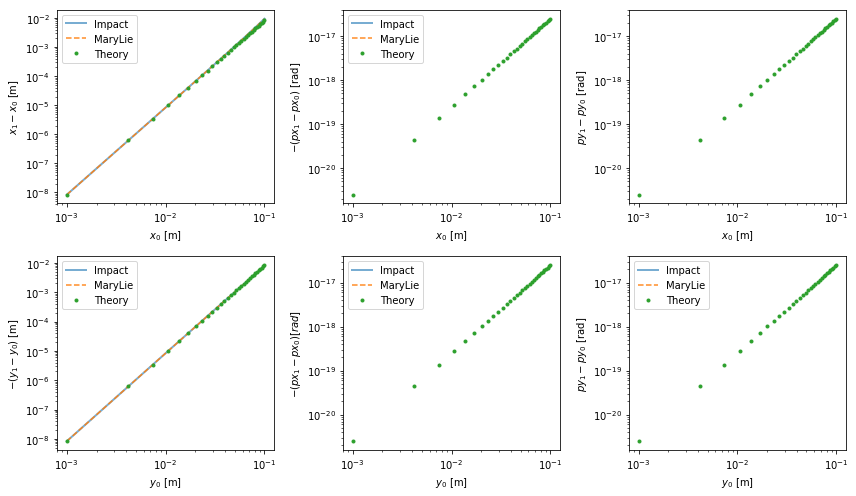

In [16]:
ep = 1.0e-16
plt.figure(figsize=(12,7))
plt.subplot(2,3,1)
plt.loglog(X,Impact_result[0][:,0],lw='2',alpha=0.6)
plt.loglog(X,MLI_result[0][:,0],'--',alpha=0.9)
plt.loglog(X,Kx/12.0*X**3,'.')
plt.xlabel('$x_0$ [m]');
plt.ylabel('$x_1-x_0$ [m]');
plt.legend(['Impact','MaryLie','Theory'])
plt.subplot(2,3,2)
plt.loglog(X,-Impact_result[0][:,1],lw='2',alpha=0.6)
plt.loglog(X,-MLI_result[0][:,1],'--',alpha=0.9)
plt.loglog(X,Kx/12.0*ep*(3*X**2+3*ep*ep-6*ep*ep),'.')
plt.xlabel('$x_0$ [m]');
plt.ylabel('$-(px_1-px_0)$ [rad]');
plt.legend(['Impact','MaryLie','Theory'])
plt.subplot(2,3,3)
plt.loglog(X,Impact_result[0][:,3],lw='2',alpha=0.6)
plt.loglog(X,MLI_result[0][:,3],'--',alpha=0.9)
plt.loglog(X,Kx/12.0*ep*(3*X**2+3*ep*ep-6*ep*ep),'.')
plt.xlabel('$x_0$ [m]');
plt.ylabel('$py_1-py_0$ [rad]');
plt.subplot(2,3,4)
plt.loglog(X,-Impact_result[2][:,2],lw='2',alpha=0.6)
plt.loglog(X,-MLI_result[2][:,2],'--',alpha=0.9)
plt.loglog(X,Kx/12.0*X**3,'.')
plt.xlabel('$y_0$ [m]');
plt.ylabel('$-(y_1-y_0)$ [m]');
plt.legend(['Impact','MaryLie','Theory'])
plt.subplot(2,3,5)
plt.loglog(X,-Impact_result[2][:,1],lw='2',alpha=0.6)
plt.loglog(X,-MLI_result[2][:,1],'--',alpha=0.9)
plt.loglog(X,Kx/12.0*ep*(3*X**2+3*ep*ep-6*ep*ep),'.')
plt.xlabel('$y_0$ [m]');
plt.ylabel('$-(px_1-px_0) [rad]$');
plt.legend(['Impact','MaryLie','Theory'])
plt.subplot(2,3,6)
plt.loglog(X,Impact_result[2][:,3],lw='2',alpha=0.6)
plt.loglog(X,MLI_result[2][:,3],'--',alpha=0.9)
plt.loglog(X,Kx/12.0*ep*(3*X**2+3*ep*ep-6*ep*ep),'.')
plt.xlabel('$y_0$ [m]');
plt.ylabel('$py_1-py_0$ [rad]');
plt.legend(['Impact','MaryLie','Theory'])
plt.tight_layout()
plt.savefig('scaling_test.log.Kx='+str(Kx)+'.N='+str(nStep)+'.png',dpi=180)

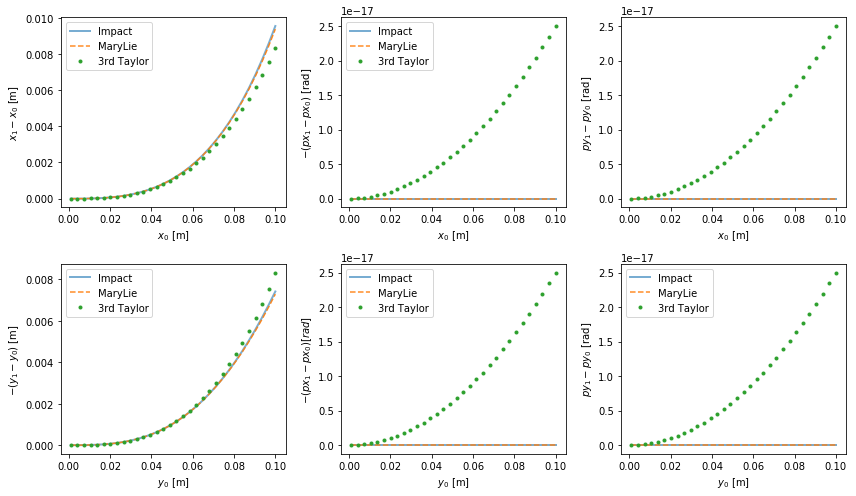

In [17]:
plt.figure(figsize=(12,7))
plt.subplot(2,3,1)
plt.plot(X,Impact_result[0][:,0],lw='2',alpha=0.6)
plt.plot(X,MLI_result[0][:,0],'--',alpha=0.9)
plt.plot(X,Kx/12.0*X**3,'.')
plt.xlabel('$x_0$ [m]');
plt.ylabel('$x_1-x_0$ [m]');
plt.legend(['Impact','MaryLie','3rd Taylor'])
plt.subplot(2,3,2)
plt.plot(X,-Impact_result[0][:,1],lw='2',alpha=0.6)
plt.plot(X,-MLI_result[0][:,1],'--',alpha=0.9)
plt.plot(X,Kx/12.0*ep*(3*X**2+3*ep*ep-6*ep*ep),'.')
plt.xlabel('$x_0$ [m]');
plt.ylabel('$-(px_1-px_0)$ [rad]');
plt.legend(['Impact','MaryLie','3rd Taylor'])
plt.subplot(2,3,3)
plt.plot(X,Impact_result[0][:,3],lw='2',alpha=0.6)
plt.plot(X,MLI_result[0][:,3],'--',alpha=0.9)
plt.plot(X,Kx/12.0*ep*(3*X**2+3*ep*ep-6*ep*ep),'.')
plt.xlabel('$x_0$ [m]');
plt.ylabel('$py_1-py_0$ [rad]');
plt.subplot(2,3,4)
plt.plot(X,-Impact_result[2][:,2],lw='2',alpha=0.6)
plt.plot(X,-MLI_result[2][:,2],'--',alpha=0.9)
plt.plot(X,Kx/12.0*X**3,'.')
plt.xlabel('$y_0$ [m]');
plt.ylabel('$-(y_1-y_0)$ [m]');
plt.legend(['Impact','MaryLie','3rd Taylor'])
plt.subplot(2,3,5)
plt.plot(X,-Impact_result[2][:,1],lw='2',alpha=0.6)
plt.plot(X,-MLI_result[2][:,1],'--',alpha=0.9)
plt.plot(X,Kx/12.0*ep*(3*X**2+3*ep*ep-6*ep*ep),'.')
plt.xlabel('$y_0$ [m]');
plt.ylabel('$-(px_1-px_0) [rad]$');
plt.legend(['Impact','MaryLie','3rd Taylor'])
plt.subplot(2,3,6)
plt.plot(X,Impact_result[2][:,3],lw='2',alpha=0.6)
plt.plot(X,MLI_result[2][:,3],'--',alpha=0.9)
plt.plot(X,Kx/12.0*ep*(3*X**2+3*ep*ep-6*ep*ep),'.')
plt.xlabel('$y_0$ [m]');
plt.ylabel('$py_1-py_0$ [rad]');
plt.legend(['Impact','MaryLie','3rd Taylor'])
plt.tight_layout()
plt.savefig('scaling_test.Kx='+str(Kx)+'.N='+str(nStep)+'.png',dpi=180)

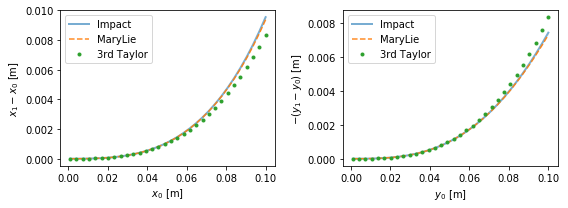

In [18]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(X,Impact_result[0][:,0],lw='2',alpha=0.6)
plt.plot(X,MLI_result[0][:,0],'--',alpha=0.9)
plt.plot(X,Kx/12.0*X**3,'.')
plt.xlabel('$x_0$ [m]');
plt.ylabel('$x_1-x_0$ [m]');
plt.legend(['Impact','MaryLie','3rd Taylor'])
plt.subplot(1,2,2)
plt.plot(X,-Impact_result[2][:,2],lw='2',alpha=0.6)
plt.plot(X,-MLI_result[2][:,2],'--',alpha=0.9)
plt.plot(X,Kx/12.0*X**3,'.')
plt.xlabel('$y_0$ [m]');
plt.ylabel('$-(y_1-y_0)$ [m]');
plt.legend(['Impact','MaryLie','3rd Taylor'])
plt.tight_layout()
plt.savefig('scaling_test.xy.Kx='+str(Kx)+'.N='+str(nStep)+'.png',dpi=180)